2024-10-02 09:15:58.914 | WARNING  | kfactory.conf:_validate_layout_cache:254 - 'cell_layout_cache' has been set to True. This might cause when as any cell names generated automatically are loaded from the layout instead of created. This could happen e.g. after reading a gds file into the layout.
2024-10-02 09:16:03.131 | INFO     | kfactory.kcell:show:8335 - klive v0.3.2: Reloaded file 'c:\Users\JUAN\PICUPVMASTER_juanferv\build\gds\617725092.oas'
2024-10-02 09:16:03.147 | WARNING  | kfactory.kcell:show:8351 - klive is out of date. Installed:0.3.2/Recommended:0.3.3. Please update it in KLayout


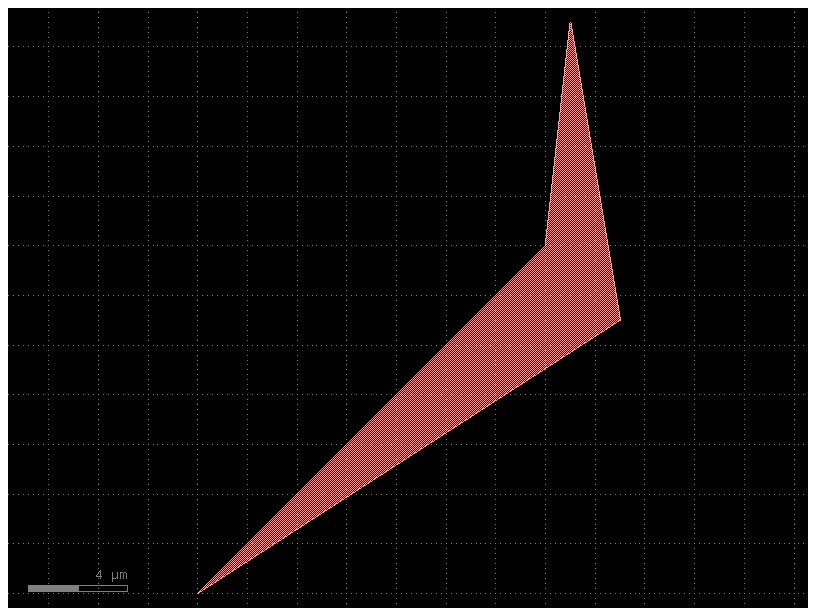

In [1]:
import gdsfactory as gf

c = (
    gf.Component()
)  # Create a blank component (essentially an empty GDS cell with some special features)
p1 = c.add_polygon([(-8, -6), (6, 8), (7, 17), (9, 5)], layer=(1, 0))
c.write_gds("demo.gds")  # write it to a GDS file. You can open it in klayout.
c.show()  # show it in klayout
c.plot()  # plot it in jupyter notebook

In [2]:
import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.port import Port

2024-10-02 09:16:05.155 | INFO     | kfactory.kcell:show:8335 - klive v0.3.2: Reloaded file 'c:\Users\JUAN\PICUPVMASTER_juanferv\build\gds\3820693039.oas'
2024-10-02 09:16:05.155 | WARNING  | kfactory.kcell:show:8351 - klive is out of date. Installed:0.3.2/Recommended:0.3.3. Please update it in KLayout
2024-10-02 09:16:05.785 | INFO     | kfactory.kcell:show:8335 - klive v0.3.2: Reloaded file 'c:\Users\JUAN\PICUPVMASTER_juanferv\build\gds\2872203883.oas'
2024-10-02 09:16:05.785 | WARNING  | kfactory.kcell:show:8351 - klive is out of date. Installed:0.3.2/Recommended:0.3.3. Please update it in KLayout
2024-10-02 09:16:19.336 | INFO     | kfactory.kcell:show:8335 - klive v0.3.2: Reloaded file 'c:\Users\JUAN\PICUPVMASTER_juanferv\build\gds\1424115403.oas'
2024-10-02 09:16:19.340 | WARNING  | kfactory.kcell:show:8351 - klive is out of date. Installed:0.3.2/Recommended:0.3.3. Please update it in KLayout
2024-10-02 09:28:01.151 | INFO     | kfactory.kcell:show:8329 - klive v0.3.2: Opened fil

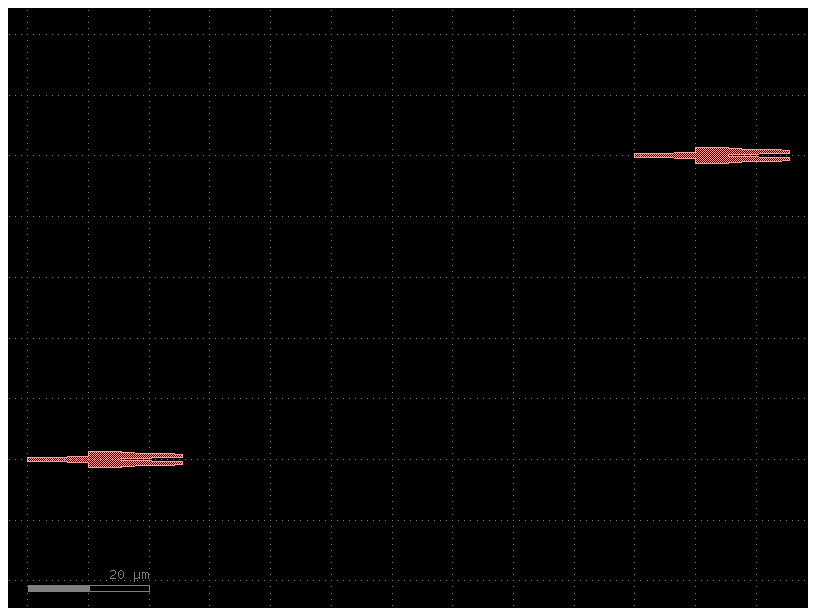

In [3]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.dmove((100, 50))
c.show()
c

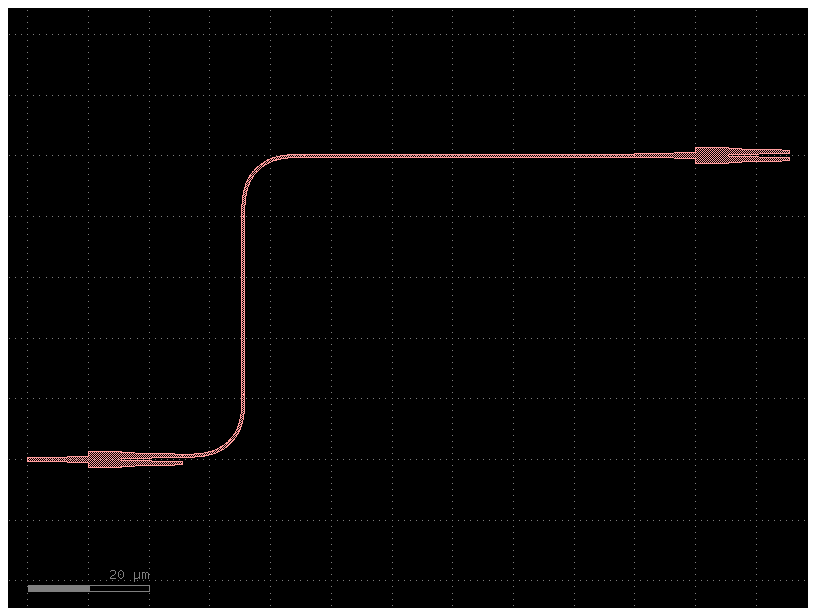

In [4]:
c = gf.Component()
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.dmove((100, 50))
route = gf.routing.route_single(c, port1=mmi1.ports["o2"], port2=mmi2.ports["o1"])
c.show()
c

In [5]:
import json
import logging
import os
import sys
from functools import partial

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meow as mw
import numpy as np
import sax
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange, tqdm

import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

In [6]:
import itertools
import json
import os
import sys
from functools import partial
from typing import List

import gdsfactory as gf  # conda install gdsfactory
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import meow as mw
import numpy as np
import sax
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from tqdm.notebook import tqdm, trange

In [7]:
from __future__ import annotations

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.components.straight import straight as straight_function
from gdsfactory.components.taper import taper as taper_function
from gdsfactory.typings import ComponentSpec, CrossSectionSpec
gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()
@gf.cell
def mmi2x25050(
    width: float | None = None,
    width_taper: float = 1.0,
    length_taper: float = 10.0,
    length_mmi: float = 5.5,
    width_mmi: float = 2.5,
    gap_mmi: float = 0.25,
    taper: ComponentSpec = taper_function,
    straight: ComponentSpec = straight_function,
    cross_section: CrossSectionSpec = "strip",
) -> Component:
    r"""Mmi 2x2.

    Args:
        width: input and output straight width.
        width_taper: interface between input straights and mmi region.
        length_taper: into the mmi region.
        length_mmi: in x direction.
        width_mmi: in y direction.
        gap_mmi: (width_taper + gap between tapered wg)/2.
        taper: taper function.
        straight: straight function.
        cross_section: spec.


    .. code::

                   length_mmi
                    <------>
                    ________
                   |        |
                __/          \__
            o2  __            __  o3
                  \          /_ _ _ _
                  |         | _ _ _ _| gap_mmi
                __/          \__
            o1  __            __  o4
                  \          /
                   |________|

                 <->
            length_taper

    """
    c = gf.Component()
    gap_mmi = gf.snap.snap_to_grid(gap_mmi, grid_factor=2)
    w_taper = width_taper
    x = gf.get_cross_section(cross_section)
    width = width or x.width

    _taper = gf.get_component(
        taper,
        length=length_taper,
        width1=width,
        width2=w_taper,
        cross_section=cross_section,
    )

    a = gap_mmi / 2 + width_taper / 2
    _ = c << gf.get_component(
        straight, length=length_mmi, width=width_mmi, cross_section=cross_section
    )

    ports = [
        gf.Port("o1", orientation=180, center=(0, -a), width=w_taper, cross_section=x),
        gf.Port("o2", orientation=180, center=(0, +a), width=w_taper, cross_section=x),
        gf.Port(
            "o3",
            orientation=0,
            center=(length_mmi, +a),
            width=w_taper,
            cross_section=x,
        ),
        gf.Port(
            "o4",
            orientation=0,
            center=(length_mmi, -a),
            width=w_taper,
            cross_section=x,
        ),
    ]

    for port in ports:
        taper_ref = c << _taper
        taper_ref.connect(port="o2", other=port, allow_width_mismatch=True)
        c.add_port(name=port.name, port=taper_ref.ports["o1"])

    c.flatten()
    return c
@gf.cell
def mmi2x27129(
    width: float | None = None,
    width_taper: float = 1.0,
    length_taper: float = 10.0,
    length_mmi: float = 5.5,
    width_mmi: float = 2.5,
    gap_mmi: float = 0.25,
    taper: ComponentSpec = taper_function,
    straight: ComponentSpec = straight_function,
    cross_section: CrossSectionSpec = "strip",
) -> Component:
    r"""Mmi 2x2.

    Args:
        width: input and output straight width.
        width_taper: interface between input straights and mmi region.
        length_taper: into the mmi region.
        length_mmi: in x direction.
        width_mmi: in y direction.
        gap_mmi: (width_taper + gap between tapered wg)/2.
        taper: taper function.
        straight: straight function.
        cross_section: spec.


    .. code::

                   length_mmi
                    <------>
                    ________
                   |        |
                __/          \__
            o2  __            __  o3
                  \          /_ _ _ _
                  |         | _ _ _ _| gap_mmi
                __/          \__
            o1  __            __  o4
                  \          /
                   |________|

                 <->
            length_taper

    """
    c = gf.Component()
    gap_mmi = gf.snap.snap_to_grid(gap_mmi, grid_factor=2)
    w_taper = width_taper
    x = gf.get_cross_section(cross_section)
    width = width or x.width

    _taper = gf.get_component(
        taper,
        length=length_taper,
        width1=width,
        width2=w_taper,
        cross_section=cross_section,
    )

    a = gap_mmi / 2 + width_taper / 2
    _ = c << gf.get_component(
        straight, length=length_mmi, width=width_mmi, cross_section=cross_section
    )

    ports = [
        gf.Port("o1", orientation=180, center=(0, -a), width=w_taper, cross_section=x),
        gf.Port("o2", orientation=180, center=(0, +a), width=w_taper, cross_section=x),
        gf.Port(
            "o3",
            orientation=0,
            center=(length_mmi, +a),
            width=w_taper,
            cross_section=x,
        ),
        gf.Port(
            "o4",
            orientation=0,
            center=(length_mmi, -a),
            width=w_taper,
            cross_section=x,
        ),
    ]

    for port in ports:
        taper_ref = c << _taper
        taper_ref.connect(port="o2", other=port, allow_width_mismatch=True)
        c.add_port(name=port.name, port=taper_ref.ports["o1"])

    c.flatten()
    return c
@gf.cell
def mmi2x29208(
    width: float | None = None,
    width_taper: float = 1.0,
    length_taper: float = 10.0,
    length_mmi: float = 5.5,
    width_mmi: float = 2.5,
    gap_mmi: float = 0.25,
    taper: ComponentSpec = taper_function,
    straight: ComponentSpec = straight_function,
    cross_section: CrossSectionSpec = "strip",
) -> Component:
    r"""Mmi 2x2.

    Args:
        width: input and output straight width.
        width_taper: interface between input straights and mmi region.
        length_taper: into the mmi region.
        length_mmi: in x direction.
        width_mmi: in y direction.
        gap_mmi: (width_taper + gap between tapered wg)/2.
        taper: taper function.
        straight: straight function.
        cross_section: spec.


    .. code::

                   length_mmi
                    <------>
                    ________
                   |        |
                __/          \__
            o2  __            __  o3
                  \          /_ _ _ _
                  |         | _ _ _ _| gap_mmi
                __/          \__
            o1  __            __  o4
                  \          /
                   |________|

                 <->
            length_taper

    """
    c = gf.Component()
    gap_mmi = gf.snap.snap_to_grid(gap_mmi, grid_factor=2)
    w_taper = width_taper
    x = gf.get_cross_section(cross_section)
    width = width or x.width

    _taper = gf.get_component(
        taper,
        length=length_taper,
        width1=width,
        width2=w_taper,
        cross_section=cross_section,
    )

    a = gap_mmi / 2 + width_taper / 2
    _ = c << gf.get_component(
        straight, length=length_mmi, width=width_mmi, cross_section=cross_section
    )

    ports = [
        gf.Port("o1", orientation=180, center=(0, -a), width=w_taper, cross_section=x),
        gf.Port("o2", orientation=180, center=(0, +a), width=w_taper, cross_section=x),
        gf.Port(
            "o3",
            orientation=0,
            center=(length_mmi, +a),
            width=w_taper,
            cross_section=x,
        ),
        gf.Port(
            "o4",
            orientation=0,
            center=(length_mmi, -a),
            width=w_taper,
            cross_section=x,
        ),
    ]

    for port in ports:
        taper_ref = c << _taper
        taper_ref.connect(port="o2", other=port, allow_width_mismatch=True)
        c.add_port(name=port.name, port=taper_ref.ports["o1"])

    c.flatten()
    return c


In [24]:
@gf.cell
def simple_mzi_mine( 
        length_y: float = 2.0,
        ):
    c = gf.Component()

    # components
    mmi_in_50550 = mmi2x25050()
    mmi_out_7129 = mmi2x27129()
    mmi_out_9208 = mmi2x29208()
    bend = gf.components.bend_euler()
    half_delay_straight = gf.components.straight(length=length_y)
    half_delay_straight2 = gf.components.straight(length=2*length_y)
    # references
    mmi_in = c.add_ref(mmi_in_50550, name="mmi_in")
    mmi_out = c.add_ref(mmi_out_7129, name="mmi_out")
    mmi_out2 = c.add_ref(mmi_out_9208, name="mmi_out2")
    straight_top1 = c.add_ref(half_delay_straight, name="straight_top1")
    straight_top2 = c.add_ref(half_delay_straight, name="straight_top2")
    straight_bot11 = c.add_ref(half_delay_straight2, name="straight_bot11")
    straight_bot21 = c.add_ref(half_delay_straight2, name="straight_bot21")
    bend_top1 = c.add_ref(bend, name="bend_top1")
    bend_top2 = c.add_ref(bend, name="bend_top2").dmirror()
    bend_top3 = c.add_ref(bend, name="bend_top3").dmirror()
    bend_top4 = c.add_ref(bend, name="bend_top4")
    bend_btm1 = c.add_ref(bend, name="bend_btm1").dmirror()
    bend_btm2 = c.add_ref(bend, name="bend_btm2")
    bend_btm3 = c.add_ref(bend, name="bend_btm3")
    bend_btm4 = c.add_ref(bend, name="bend_btm4").dmirror()
    bend_top11 = c.add_ref(bend, name="bend_top11")
    bend_top21 = c.add_ref(bend, name="bend_top21").dmirror()
    bend_top31 = c.add_ref(bend, name="bend_top31").dmirror()
    bend_top41 = c.add_ref(bend, name="bend_top41")
    bend_btm11 = c.add_ref(bend, name="bend_btm11").dmirror()
    bend_btm21 = c.add_ref(bend, name="bend_btm21")
    bend_btm31 = c.add_ref(bend, name="bend_btm31")
    bend_btm41 = c.add_ref(bend, name="bend_btm41").dmirror()
    # connections
    bend_top1.connect("o1", mmi_in.ports["o3"])
    straight_top1.connect("o1", bend_top1.ports["o2"])
    bend_top2.connect("o1", straight_top1.ports["o2"])
    bend_top3.connect("o1", bend_top2.ports["o2"])
    straight_top2.connect("o1", bend_top3.ports["o2"])
    bend_top4.connect("o1", straight_top2.ports["o2"])

    bend_btm1.connect("o1", mmi_in.ports["o4"])
    bend_btm2.connect("o1", bend_btm1.ports["o2"])
    bend_btm3.connect("o1", bend_btm2.ports["o2"])
    bend_btm4.connect("o1", bend_btm3.ports["o2"])

    mmi_out.connect("o1", bend_btm4.ports["o2"])

    bend_top11.connect("o1", mmi_out.ports["o3"])
    bend_top21.connect("o1", bend_top11.ports["o2"])
    bend_top31.connect("o1", bend_top21.ports["o2"])
    bend_top41.connect("o1", bend_top31.ports["o2"])

    bend_btm11.connect("o1", mmi_out.ports["o4"])
    straight_bot11.connect("o1", bend_btm11.ports["o2"])
    bend_btm21.connect("o1", straight_bot11.ports["o2"])
    bend_btm31.connect("o1", bend_btm21.ports["o2"])
    straight_bot21.connect("o1", bend_btm31.ports["o2"])
    bend_btm41.connect("o1", straight_bot21.ports["o2"])

    mmi_out2.connect("o1", bend_btm41.ports["o2"])
    # ports
    c.add_port("o1", port=mmi_in.ports["o1"])
    c.add_port("o2", port=mmi_in.ports["o2"])
    c.add_port("o3", port=mmi_out2.ports["o3"])
    c.add_port("o4", port=mmi_out2.ports["o4"])
    return c

In [25]:
mzi_mine = simple_mzi_mine(length_y=10.0)
mzi_mine.show()

mzi_mine.get_netlist(recursive=True)
# print(mzi_mine.get_netlist(recursive=True))



{
    'simple_mzi_mine_LY10': {
        'nets': (
            {'p1': 'bend_btm1,o1', 'p2': 'mmi_in,o4'},
            {'p1': 'bend_btm1,o2', 'p2': 'bend_btm2,o1'},
            {'p1': 'bend_btm11,o1', 'p2': 'mmi_out,o4'},
            {'p1': 'bend_btm11,o2', 'p2': 'straight_bot11,o1'},
            {'p1': 'bend_btm2,o2', 'p2': 'bend_btm3,o1'},
            {'p1': 'bend_btm21,o1', 'p2': 'straight_bot11,o2'},
            {'p1': 'bend_btm21,o2', 'p2': 'bend_btm31,o1'},
            {'p1': 'bend_btm3,o2', 'p2': 'bend_btm4,o1'},
            {'p1': 'bend_btm31,o2', 'p2': 'straight_bot21,o1'},
            {'p1': 'bend_btm4,o2', 'p2': 'mmi_out,o1'},
            {'p1': 'bend_btm41,o1', 'p2': 'straight_bot21,o2'},
            {'p1': 'bend_btm41,o2', 'p2': 'mmi_out2,o1'},
            {'p1': 'bend_top1,o1', 'p2': 'mmi_in,o3'},
            {'p1': 'bend_top1,o2', 'p2': 'straight_top1,o1'},
            {'p1': 'bend_top11,o1', 'p2': 'mmi_out,o3'},
            {'p1': 'bend_top11,o2', 'p2': 'bend_top21,o1'},

In [26]:
def model_mmi2x2_5050(wl=1.31) -> sax.SDict:
    # cross power splitting ratio is 0.5 and the direct is 0.5
    S = {
        ("o1", "o3"): 0.5**0.5,
        ("o1", "o4"): 1j * 0.5**0.5,
        ("o2", "o3"): 1j * 0.5**0.5,
        ("o2", "o4"): 0.5**0.5,
    }
    return sax.reciprocal(S)

In [47]:
def model_mmi2x2_7129(wl=1.31)-> sax.SDict:
    # cross power splitting ratio is 0.29 and the direct is 0.71
    S = {
        ("o1", "o3"): 0.29**0.5,
        ("o1", "o4"): 1j * 0.71**0.5,
        ("o2", "o3"): 1j * 0.71**0.5,
        ("o2", "o4"): 0.29**0.5,
    }
    return sax.reciprocal(S)

In [48]:
def model_mmi2x2_9208(wl=1.31)-> sax.SDict:
    # cross power splitting ratio is 0.08 and the direct is 0.92
    S = {
        ("o1", "o3"): 0.08**0.5,
        ("o1", "o4"): 1j * 0.92**0.5,
        ("o2", "o3"): 1j * 0.92**0.5,
        ("o2", "o4"): 0.08**0.5,
    }
    return sax.reciprocal(S)

In [40]:
from sax.saxtypes import FloatArrayND, Model, SCoo, SDict
from sax.utils import get_inputs_outputs, reciprocal
def model_straight(
    wl: FloatArrayND | float = 1.55,
    wl0: float = 1.55,
    neff: float = 2.34,
    ng: float = 3.4,
    length: float = 10.0,
    loss: float = 0.0,
) -> SDict:
    """A simple straight waveguide model.

    Args:
        wl: wavelength in microns.
        wl0: reference wavelength in microns.
        neff: effective index.
        ng: group index.
        length: length of the waveguide in microns.
        loss: loss in dB/cm.

    """
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    _neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * _neff * length / wl
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

def model_bendeuler(
    radius: float =10.0,
    angle: float = 90.0,
    p: float = 0.5,
    with_arc_floorplan: bool = True,
    npoints: int | None = None,
    layer: gf.typings.LayerSpec | None = None,
    width: float | None = None,
    cross_section: CrossSectionSpec = "strip",
    allow_min_radius_violation: bool = False,
    wl: FloatArrayND | float = 1.55,
    wl0: float = 1.55,
    neff: float = 2.34,
    ng: float = 3.4,
    # length: float = 10.0,
    loss: float = 0.0,
) -> SDict:
    """A simple straight waveguide model.

    Args:
        wl: wavelength in microns.
        wl0: reference wavelength in microns.
        neff: effective index.
        ng: group index.
        length: length of the waveguide in microns.
        loss: loss in dB/cm.

    """
    length = np.pi*(angle/180.0)*radius
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    _neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * _neff * length / wl
    amplitude = jnp.asarray(10 ** (-loss * length / 20), dtype=complex)
    transmission = amplitude * jnp.exp(1j * phase)
    return reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )
models = {
    "mmi2x25050": model_mmi2x2_5050,
    "mmi2x27129": model_mmi2x2_7129,
    "mmi2x29208": model_mmi2x2_9208,
    "straight": model_straight,
    "bend_euler": model_bendeuler,
}
from sax.netlist import netlist as parse_netlist
recnet = parse_netlist(
    mzi_mine.get_netlist(recursive=True), with_unconnected_instances=False, with_placements=False
)
net= recnet.root[list(recnet.root)[0]]
print(mzi_mine.get_netlist(recursive=True))
mzi1, _ = sax.circuit(mzi_mine.get_netlist(recursive=True), models=models,ignore_missing_ports=False)


{'simple_mzi_mine_LY10': {'nets': ({'p1': 'bend_btm1,o1', 'p2': 'mmi_in,o4'}, {'p1': 'bend_btm1,o2', 'p2': 'bend_btm2,o1'}, {'p1': 'bend_btm11,o1', 'p2': 'mmi_out,o4'}, {'p1': 'bend_btm11,o2', 'p2': 'straight_bot11,o1'}, {'p1': 'bend_btm2,o2', 'p2': 'bend_btm3,o1'}, {'p1': 'bend_btm21,o1', 'p2': 'straight_bot11,o2'}, {'p1': 'bend_btm21,o2', 'p2': 'bend_btm31,o1'}, {'p1': 'bend_btm3,o2', 'p2': 'bend_btm4,o1'}, {'p1': 'bend_btm31,o2', 'p2': 'straight_bot21,o1'}, {'p1': 'bend_btm4,o2', 'p2': 'mmi_out,o1'}, {'p1': 'bend_btm41,o1', 'p2': 'straight_bot21,o2'}, {'p1': 'bend_btm41,o2', 'p2': 'mmi_out2,o1'}, {'p1': 'bend_top1,o1', 'p2': 'mmi_in,o3'}, {'p1': 'bend_top1,o2', 'p2': 'straight_top1,o1'}, {'p1': 'bend_top11,o1', 'p2': 'mmi_out,o3'}, {'p1': 'bend_top11,o2', 'p2': 'bend_top21,o1'}, {'p1': 'bend_top2,o1', 'p2': 'straight_top1,o2'}, {'p1': 'bend_top2,o2', 'p2': 'bend_top3,o1'}, {'p1': 'bend_top21,o2', 'p2': 'bend_top31,o1'}, {'p1': 'bend_top3,o2', 'p2': 'straight_top2,o1'}, {'p1': 'bend_

c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\site-packages\jax\_src\numpy\lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\site-packages\jax\_src\numpy\lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\site-packages\jax\_src\numpy\lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\si

c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\site-packages\jax\_src\numpy\lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\site-packages\jax\_src\numpy\lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\site-packages\jax\_src\numpy\lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
c:\ProgramData\miniforge-pypy3\envs\PICUPVMASTER_juanferv\Lib\si

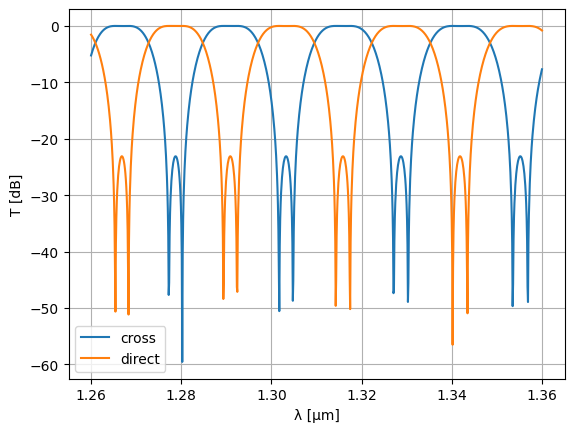

In [51]:
wls = jnp.linspace(1.26, 1.36, 1000)
S = mzi1(wl=wls)
plt.plot(wls, 10*np.log10(abs(S["o1", "o3"]) ** 2))
plt.plot(wls, 10*np.log10(abs(S["o1", "o4"]) ** 2))
# plt.ylim(-0.05, 1.05)
plt.xlabel("λ [μm]")
plt.ylabel("T [dB]")
plt.legend(["cross", "direct"])
plt.grid(True)
plt.show()